In [2]:
%matplotlib inline
from sys import path
path.append('/home/rui/blacksid/mew-p')
DATA_PATH = '/home/rui/blacksid/data/dockfuture'
import numpy as np
import pytz
from datetime import datetime
from datetime import timedelta
import cProfile
import matplotlib.pyplot as plt
from mewp.data.item import Contract
from mewp.simulate.wrapper import TrendAlgoWrapper
from mewp.simulate.runner import SingleRunner
import pandas as pd
from mewp.util.clock import Clock
from mewp.util.candle import Candle
from mewp.util.candle import CandleCreator
from mewp.util.candle import CandleAnalysis

In [3]:
contract = Contract('zn')
contract.units

5

In [4]:
def make_candle(product):
    data = pd.read_csv('/home/rui/blacksid/data/adjusted_5min/{}0.csv'.format(product.upper()))
    candles = []
    mins_5 = timedelta(seconds= 5*60)
    contract = Contract(product)
    units = contract.units
    for row in data.iterrows():
        if row[1].TotalVolumeTraded < 0.1:
            continue
        time2 = datetime.strptime(row[1].datetime, '%Y-%m-%d %H:%M:%S')
        time1 = time2 - mins_5
        start_time = int((time1 - datetime(1970, 1, 1)).total_seconds() * 1000)
        end_time = int((time2 - datetime(1970, 1, 1)).total_seconds() * 1000)
        adjust = row[1].adjust
        day_info = {}
        day_info['HighPrice'] = row[1].HighPx + adjust
        day_info['LowPrice'] = row[1].LowPx + adjust
        day_info['OpenPrice'] = row[1].OpeningPx + adjust
        day_info['ClosePrice'] = row[1].ClosingPx + adjust
        day_info['Volume'] = row[1].TotalVolumeTraded
        day_info['SettlePrice'] = row[1].TotalTurnover/row[1].TotalVolumeTraded/units + adjust   # vwap
        day_info['Position'] = 0
        day_info['LastPosition'] = 0
        temp_candle = Candle(day_info, start_time, end_time)
        candles.append(temp_candle)
    return candles

In [5]:
class AlgoBase(object):
    def __init__(self, product):
        self.contract = Contract(product)
        self.pos = 0
        self.cash = 0
        self._pre_day = None
        self._pre_pnl = 0
        self.daily_checkpoint = {'day':[], 'pnl':[]}
        self.pnl_history = []
    
    def _long(self, qty, price):
        self.pos += qty
        self.cash -= qty * price * self.contract.units
        self.cash -= qty * price * self.contract.units * self.contract.fee_peramount
        self.cash -= qty * self.contract.fee_perhand        
    
    def _short(self, qty, price):
        self.pos -= qty
        self.cash += qty * price * self.contract.units
        self.cash -= qty * price * self.contract.units * self.contract.fee_peramount
        self.cash -= qty * self.contract.fee_perhand
    
    def _order_to(self, qty, price):
        if qty == self.pos:
            return
        elif qty>self.pos:
            self._long(qty-self.pos, price)
        else:
            self._short(self.pos - qty, price)
            
    def on_candle(self, candle, next_open_price):
        pass
    
    def pnl_checkpoint(self, pnl, date_time):
        if self._pre_day == None:
            self.daily_checkpoint['day'].append(date_time.date().strftime("%Y-%m-%d"))
            self.daily_checkpoint['pnl'].append(pnl)
            self._pre_day = date_time.date()
            self._pre_pnl = pnl
        elif date_time.date() == self._pre_day:
            return
        else:
            self.daily_checkpoint['day'].append(date_time.date().strftime("%Y-%m-%d"))
            self.daily_checkpoint['pnl'].append(pnl-self._pre_pnl)
            self._pre_day = date_time.date()
            self._pre_pnl = pnl

In [6]:
class ATR(object):
    ## Constructor
    # @param alpha for ema
    def __init__(self, alpha):
        self.alpha = alpha
        # computed
        self.mean = 0
        
    ## add a new observation, and refresh
    def add(self, observe):
        if (self.mean == 0):
            self.mean = observe
        else:
            self.mean = self.mean + self.alpha * (observe - self.mean)

class MACross(AlgoBase):
    def __init__(self, product, param):
        super(MACross, self).__init__(product)
        self.pre_close_price = []
        self.pre_vwap = []
        self.param = param
        self.atr = ATR(self.param['alpha'])
        self.trade_day_list = []
        self.window = max(self.param['ma2'], self.param['filter2'])
        self.pre_cross = None
        self.pre_high = None
        self.pre_low = None
        
    
    # def buy_filter(self):
    #     if np.mean(self.pre_vwap[-self.param['filter1']:]) >\
    #         np.mean(self.pre_vwap[-self.param['filter2']:]):
    #         return True
    #     else:
    #         return False
    # 
    # def sell_filter(self):
    #     if np.mean(self.pre_vwap[-self.param['filter1']:]) <\
    #         np.mean(self.pre_vwap[-self.param['filter2']:]):
    #         return True
    #     else:
    #         return False
    
    def buy_filter(self):
        return True
    def sell_filter(self):
        return True
    
    def on_candle(self, candle):
        date_time = datetime.fromtimestamp(candle.start_time/1000)
        self.pre_close_price.append(candle.close_price)
        self.pre_vwap.append(candle.vwap)
        if len(self.pre_close_price) > 1:
            TR = max(self.pre_close_price[-2], candle.high) - min(self.pre_close_price[-2], candle.low)
            self.atr.add(TR)
        if len(self.pre_close_price) < self.window:
            self.pnl_history.append(0)
            return
        if len(self.pre_close_price) > self.window:
            self.pre_close_price.pop(0)
            self.pre_vwap.pop(0)
            
        if self.pre_cross == None:
            if np.mean(self.pre_vwap[-self.param['ma1']:]) >\
                np.mean(self.pre_vwap[-self.param['ma2']:]):
                self.pre_cross = 1
            else:
                self.pre_cross = -1
            self.pnl_history.append(0)
            return
        if np.mean(self.pre_vwap[-self.param['ma1']:]) >\
                np.mean(self.pre_vwap[-self.param['ma2']:]):
            cross = 1
        else:
            cross = -1

        if cross == 1 and self.pre_cross == -1 and self.buy_filter():
                self._order_to(self.param['hands'], candle.close_price)
                self.pre_high = candle.close_price
        elif cross == -1 and self.pre_cross == 1 and self.sell_filter():
                self._order_to(-self.param['hands'], candle.close_price)
                self.pre_low = candle.close_price
        # stop_loss 
        if self.pos > 0:
            assert(self.pre_high!=None)
            if candle.close_price > self.pre_high:
                self.pre_high = candle.close_price
            diff = self.pre_high - candle.close_price
            assert(diff>=-1e-6)
            if diff > self.param['atr_stop_loss'] * self.atr.mean:
                self._order_to(0, candle.close_price)
                self.pre_high = None
            
        if self.pos < 0:
            assert(self.pre_low!=None)
            if candle.close_price < self.pre_low:
                self.pre_low = candle.close_price
            diff = candle.close_price - self.pre_low
            assert(diff>=-1e-6)
            if diff > self.param['atr_stop_loss'] * self.atr.mean:
                self._order_to(0, candle.close_price)
                self.pre_low = None
        self.pre_cross = cross
        pnl = self.pos * candle.close_price * self.contract.units + self.cash
        self.pnl_history.append(pnl)
        self.pnl_checkpoint(pnl, date_time)

In [9]:
def back_test(product, param):
    candles = make_candle(product)
    Account = MACross(product,param)
    for i in range(len(candles)-1):
        Account.on_candle(candles[i])
    print 'total pnl: {}'.format(Account.pnl_history[-1])
    plt.plot(Account.pnl_history)
    return (Account.daily_checkpoint, Account.atr.mean)

In [10]:
param = {'ma1':10, 'ma2':100, 'filter1':50, 'filter2':100, 'atr_stop_loss': 10, 'alpha': 0.07, 'hands': 1}

In [11]:
product_list = ['au','cu','i','m','cs','rb','j','ru']
result = {}

total pnl: 305390.0
total pnl: 126371.5225
total pnl: 51349.26
total pnl: 12077.5
total pnl: 9412.5
total pnl: 42864.30451
total pnl: 182938.148
total pnl: 317643.184642


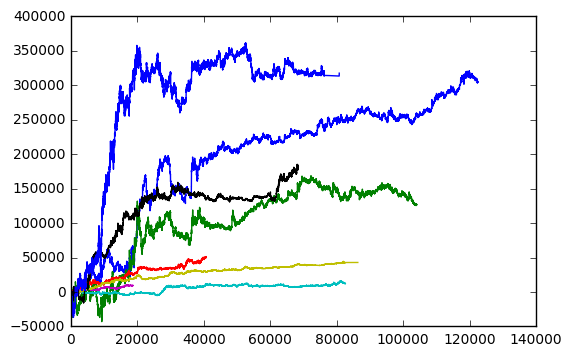

In [12]:
for product in product_list:
    daily_result, atr = back_test(product, param)
    result[product] = (daily_result,atr)

In [13]:
for key in result.keys():
    print '{} days: {}'.format(key,len(result[key][0]['day']))

ru days: 1604
i days: 693
j days: 1299
m days: 1607
au days: 1605
rb days: 1580
cs days: 404
cu days: 1605


In [14]:
df = None
for key in result.keys():
    temp = pd.DataFrame(data = result[key][0]['pnl'], index = result[key][0]['day'])
    temp.columns = [key]
    df = pd.concat([df, temp], axis = 1)

In [15]:
pnl_matrix = df.fillna(value=0).as_matrix()

In [16]:
df.columns

Index([u'ru', u'i', u'j', u'm', u'au', u'rb', u'cs', u'cu'], dtype='object')

In [17]:
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
np.corrcoef(pnl_matrix.transpose())

array([[ 1.00,  0.04,  0.22,  0.12,  0.12,  0.23, -0.02,  0.37],
       [ 0.04,  1.00,  0.21, -0.01, -0.02,  0.19, -0.02,  0.06],
       [ 0.22,  0.21,  1.00,  0.03,  0.06,  0.28,  0.04,  0.14],
       [ 0.12, -0.01,  0.03,  1.00,  0.00,  0.03, -0.00,  0.06],
       [ 0.12, -0.02,  0.06,  0.00,  1.00,  0.05,  0.00,  0.19],
       [ 0.23,  0.19,  0.28,  0.03,  0.05,  1.00, -0.03,  0.23],
       [-0.02, -0.02,  0.04, -0.00,  0.00, -0.03,  1.00, -0.01],
       [ 0.37,  0.06,  0.14,  0.06,  0.19,  0.23, -0.01,  1.00]])

In [18]:
np.set_printoptions(precision=3)
ratio = np.zeros(8)
i = 0
for symbol in result.keys():
    contract = Contract(symbol)
    ratio[i] = 1/(result[symbol][1] * contract.units)
    i+=1

In [19]:
result.keys()

['ru', 'i', 'j', 'm', 'au', 'rb', 'cs', 'cu']

In [20]:
ratio * 2000

array([  3.098e+00,   9.677e+00,   4.113e+00,   3.065e+01,   1.073e+01,
         3.724e+03,   5.281e+01,   1.057e+01])

# portfolio: 

ru: 3
    
i: 10

j: 4
    
m: 30
    
au: 10
    
rb: 200
    
cs: 50
    
cu 10

total capital: 14,000,000

In [21]:
ratio = [3,10,4,30,10,200,50,10]

In [22]:
pnl = np.sum(pnl_matrix * np.asarray(ratio),1)

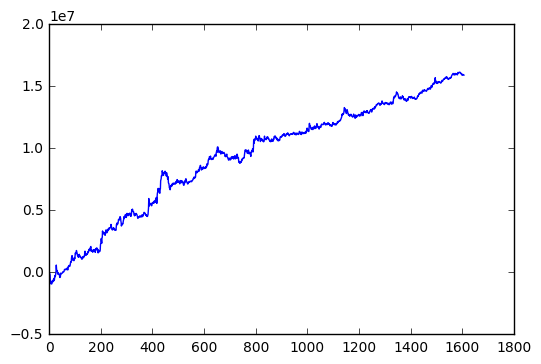

In [23]:
plt.plot(np.cumsum(pnl))

In [27]:
def annualised_sharpe(returns, N=252):
    return np.sqrt(N) * returns.mean() / returns.std()

In [28]:
annualised_sharpe(pnl)

1.5816486650012571

In [29]:
sum(pnl)

15910481.4909245

In [34]:
np.log(16/14.0+1)/(1600/252.0)

0.12003705819738623